In [1]:
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# import mplfinance as mpf
import yfinance as yf
from talib import abstract
# add base to the modules
from indicators import indicators as ind
from indicators import normalize as nor
from matplotlib import pyplot as plt
import math
import pathlib
from typing import Dict, List, Tuple, Union
# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path)

plt.style.use('dark_background')
%matplotlib inline

### load ticker function

In [2]:
def load_ticker(sym, period="5y", interval="1d"):
    return yf.Ticker(sym).history(period, interval).reset_index()


In [3]:
def load_tickers(symbols: list, period="5y", interval="1d") -> Dict[str, pd.DataFrame]:
    frames: Dict[str, pd.DataFrame] = {}
    for sym in symbols:
        frames[sym] = load_ticker(sym, period, interval)
    return frames

In [4]:
def plot_tickers(frames: Dict[str, pd.DataFrame]):
    for symbol, df in frames.items():
        plt.figure(figsize=(18,6))
        df["Close"].plot(title=f"{symbol} Close")
    plt.show()

In [5]:
tickers = load_tickers(['SPY', 'QQQ'])

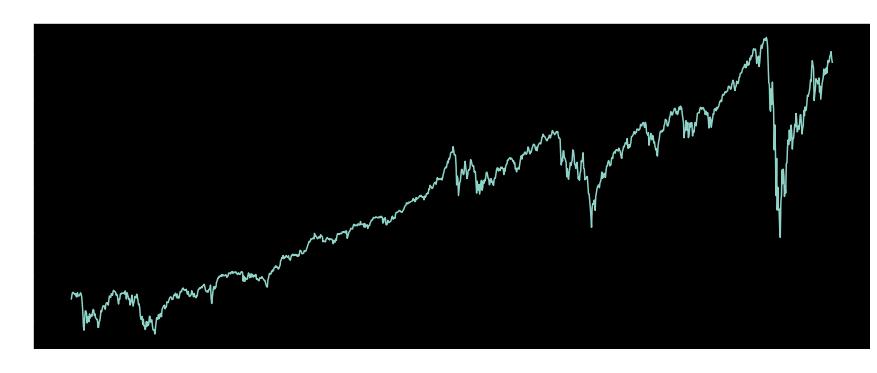

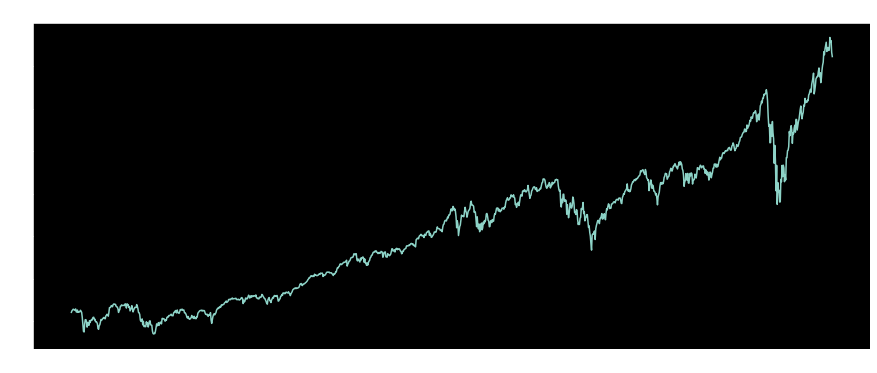

In [6]:
plot_tickers(tickers)

In [ ]:
def add_indicators(df: pd.DataFrame) -> pd.DataFrame:
    periods = []
    sar_periods = []
    for i in range(12):
        periods = 3 + i + (i*2)
        sar_periods = math.floor((i+1)/100)
    print(f"periods: {periods}, sar_periods: {sar_periods}")
    
    indicators: List[ind.Indicator] = []

    # set the mid price
    i_mid = ind.Mid()
    df[i_mid.name] = i_mid(df['Open'].values, df['Close'].values)

    # numpy-ize
    o = df['Open'].to_numpy()
    h = df['High'].to_numpy()
    l = df['Low'].to_numpy()
    c = df['Close'].to_numpy()
    m = df['Mid'].to_numpy()

    # add candles patterns
    df = ind.CNDL().concat_to_frame(df)
    
    # add periodic indicators
    for i in periods:
        # EMA
        df = ind.EMA(i).concat_to_frame(df)
        # linear regression
        df[f'LREG_{i}'] = ind.rolling_lin(m, i)
        # SMAs
        i_sma = ind.SMA(i)
        df[i_sma.name] = ind.sma(c, i)
        # BBANDs and Keltner channels
        bb2u, _, bb2l = ind.bbands(c, i, 2.)
        bb3u, _, bb3l = ind.bbands(c, i, 3.)
        ku, kl, _ = ind.keltner_channels(h, l, c, i)
        df[f'BB3U_{i}'] = bb3u
        df[f'BB2U_{i}'] = bb2u
        df[f'KELU_{i}'] = ku
        df[f'KELL_{i}'] = kl
        df[f'BB2L_{i}'] = bb2l
        df[f'BB3L_{i}'] = bb3l

    # add sar
    for i in sar_periods:
        df[f'SAR_{i}'] = ind.sar(h, l, i, 1.)